# Preparamos el entorno y creamos el modelo predictivo

Importamos las librerias nesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib

Cargamos los datos

In [2]:
df = pd.read_csv("datos_procesados.csv")
df['date'] = pd.to_datetime(df['date'])

Tratamos los nulos

In [3]:
nulos_antes = df.isnull().sum()
    
# Imprimimos información sobre los valores nulos
if nulos_antes.sum() > 0:
    print(f"Se encontraron {nulos_antes.sum()} valores nulos:")
    print(nulos_antes[nulos_antes > 0])
    
    # Si hay nulos en variables climáticas críticas, usamos interpolación
    for col in ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres', 'wdir']:
        if col in df.columns and df[col].isnull().sum() > 0:
            df[col] = df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    
    # Verificamos si quedan valores nulos después de la limpieza
    nulos_despues = df.isnull().sum()
    if nulos_despues.sum() > 0:
        print(f"Después de la limpieza quedan {nulos_despues.sum()} valores nulos:")
        print(nulos_despues[nulos_despues > 0])
        
        # Como último recurso, eliminamos las filas que aún tengan nulos en las columnas más críticas
        columnas_criticas = ['date', 'prcp']
        df = df.dropna(subset=columnas_criticas)
        print(f"Se eliminaron filas con valores nulos en columnas críticas. Filas restantes: {len(df)}")

Se encontraron 18633 valores nulos:
wdir    6211
wspd    6211
pres    6211
dtype: int64


C:\Users\franb\AppData\Local\Temp\ipykernel_13304\2393497995.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


Preparamos los datos para el entrenamiento

In [4]:
# Creamos variable objetivo: 1 si llueve, 0 si no llueve
df['rain_tomorrow'] = df['prcp'].shift(-1) > 0
df['rain_tomorrow'] = df['rain_tomorrow'].astype(int)

# Eliminamos el último registro que no tendrá valor para 'rain_tomorrow'
df = df[:-1]

# Creamos características basadas en la fecha
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['day_of_week'] = df['date'].dt.dayofweek
df['season'] = (df['month'] % 12 + 3) // 3

# Creamos características de tendencia
df['tavg_3d_mean'] = df['tavg'].rolling(window=3).mean()
df['prcp_3d_sum'] = df['prcp'].rolling(window=3).sum()
df['pres_diff'] = df['pres'].diff()

# Llenamos valores faltantes que pueden surgir del rolling y diff
df = df.fillna(method='bfill')

# Variables cíclicas (dirección del viento)
df['wdir_sin'] = np.sin(np.radians(df['wdir']))
df['wdir_cos'] = np.cos(np.radians(df['wdir']))

C:\Users\franb\AppData\Local\Temp\ipykernel_13304\1743645927.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


Seleccionamos características y dividimos en conjuntos de entrenamiento y prueba

In [5]:
features = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres', 
            'month', 'day_of_year', 'day_of_week', 'season',
            'tavg_3d_mean', 'prcp_3d_sum', 'pres_diff',
            'wdir_sin', 'wdir_cos']
    
X = df[features]
y = df['rain_tomorrow']
    
# Dividimos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# Escalamos las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Entrenamos y optimizamos el modelo

In [6]:
# Definimos parámetros para GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializamos el clasificador Random Forest
rf = RandomForestClassifier(random_state=42)

# Realizamos búsqueda de hiperparámetros
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Obtenemos el mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores hiperparámetros: {grid_search.best_params_}")


Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


Evaluamos el modelo


Informe de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1185
           1       0.60      0.43      0.50       348

    accuracy                           0.80      1533
   macro avg       0.72      0.67      0.69      1533
weighted avg       0.79      0.80      0.79      1533



<function matplotlib.pyplot.show(close=None, block=None)>

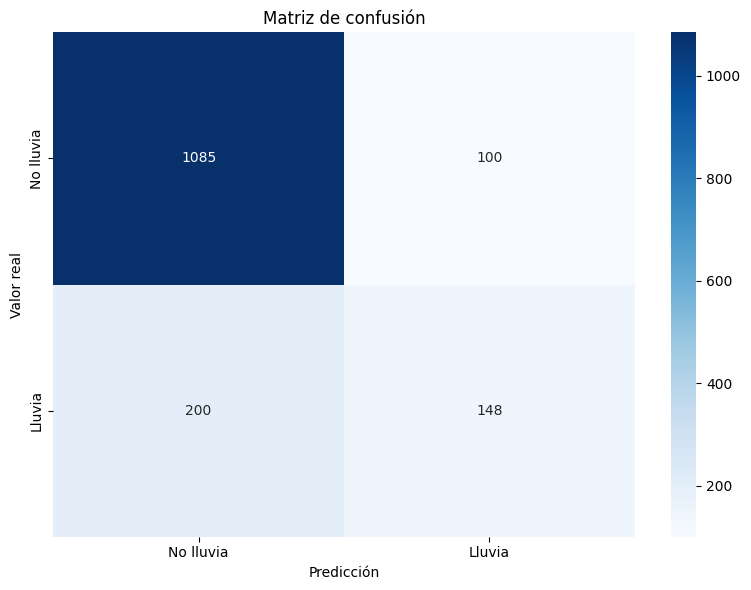

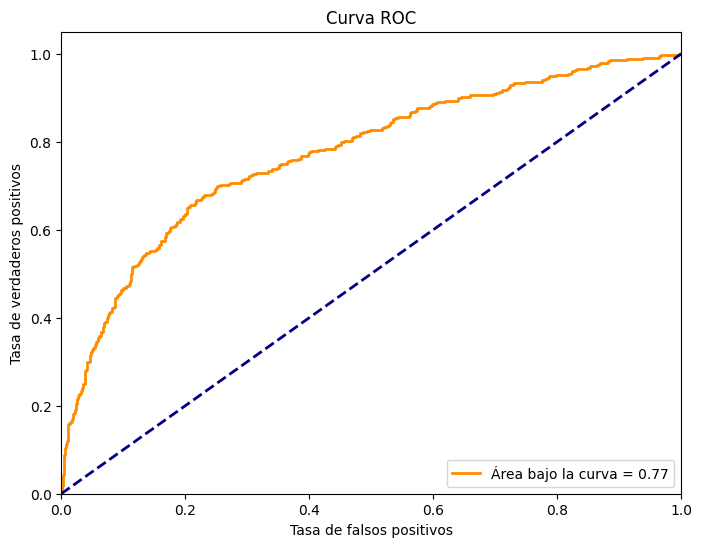

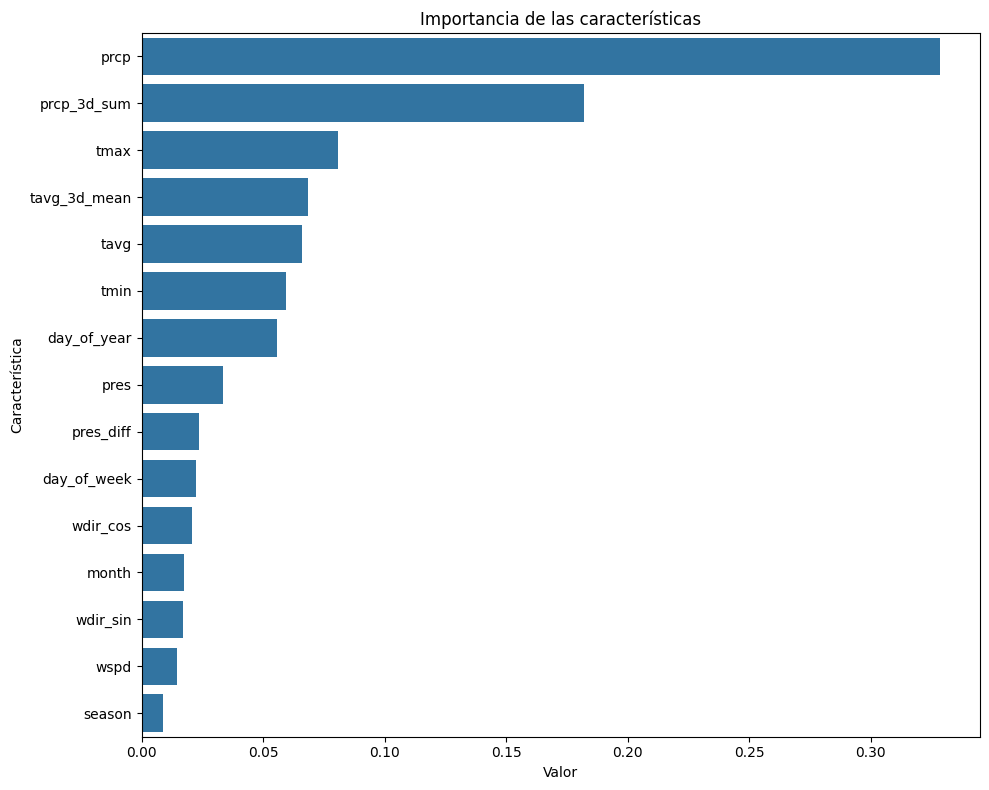

In [7]:
# Realizamos predicciones
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Mostramos métricas de evaluación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No lluvia', 'Lluvia'],
            yticklabels=['No lluvia', 'Lluvia'])
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión')
plt.tight_layout()
plt.show

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Área bajo la curva = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show

# Importancia de características
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, features)),
                           columns=['Valor', 'Característica'])

plt.figure(figsize=(10, 8))
sns.barplot(x="Valor", y="Característica", data=feature_imp.sort_values(by="Valor", ascending=False))
plt.title('Importancia de las características')
plt.tight_layout()
plt.show

Guardamos el modelo y el escalador

In [10]:
joblib.dump(best_model, 'model/rain_prediction_model.pkl')
joblib.dump(scaler, 'model/scaler.pkl')
joblib.dump(features, 'model/features.pkl')

print("Modelo guardado con éxito.")

Modelo guardado con éxito.


Probamos a predecir lluvia

In [11]:
df_ultimo_dia = df.iloc[-1:].copy()

# Cargamos modelo, escalador y características
model = joblib.load("model/rain_prediction_model.pkl")
scaler = joblib.load("model/scaler.pkl")
features = joblib.load("model/features.pkl")

# Preparar datos nuevos
datos_nuevos = df_ultimo_dia[features]
datos_nuevos_scaled = scaler.transform(datos_nuevos)

# Realizar predicción
probabilidad = model.predict_proba(datos_nuevos_scaled)[:, 1]
prediccion = model.predict(datos_nuevos_scaled)

print(f"Predicción para el día {df_ultimo_dia['date'].values[0]}: {'Lluvia' if prediccion[0] == 1 else 'No lluvia'}")
print(f"Probabilidad de lluvia: {probabilidad[0] * 100:.2f}%")

Predicción para el día 2024-12-30T00:00:00.000000000: No lluvia
Probabilidad de lluvia: 16.87%


Análisis estacional

<function matplotlib.pyplot.show(close=None, block=None)>

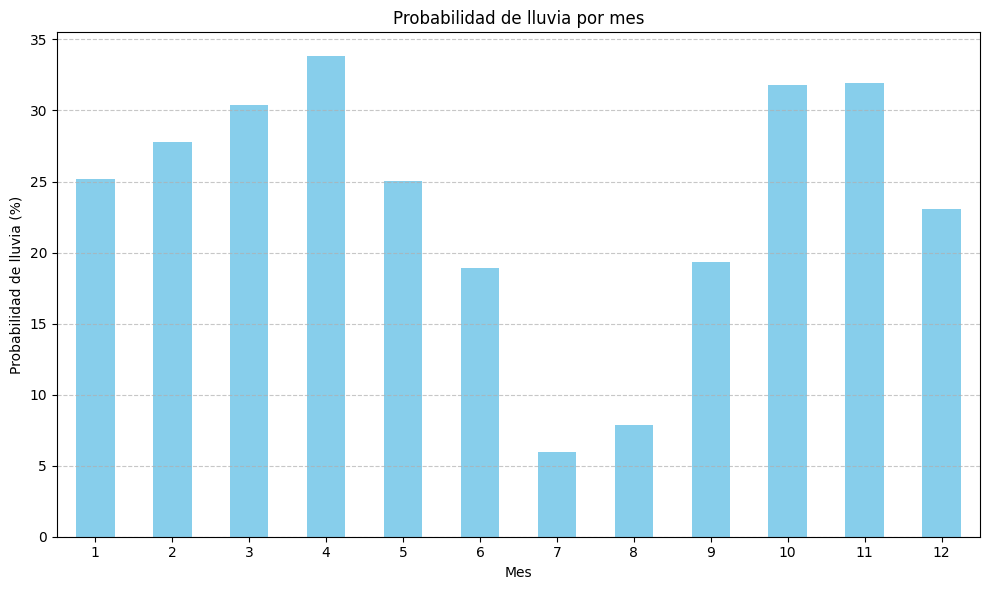

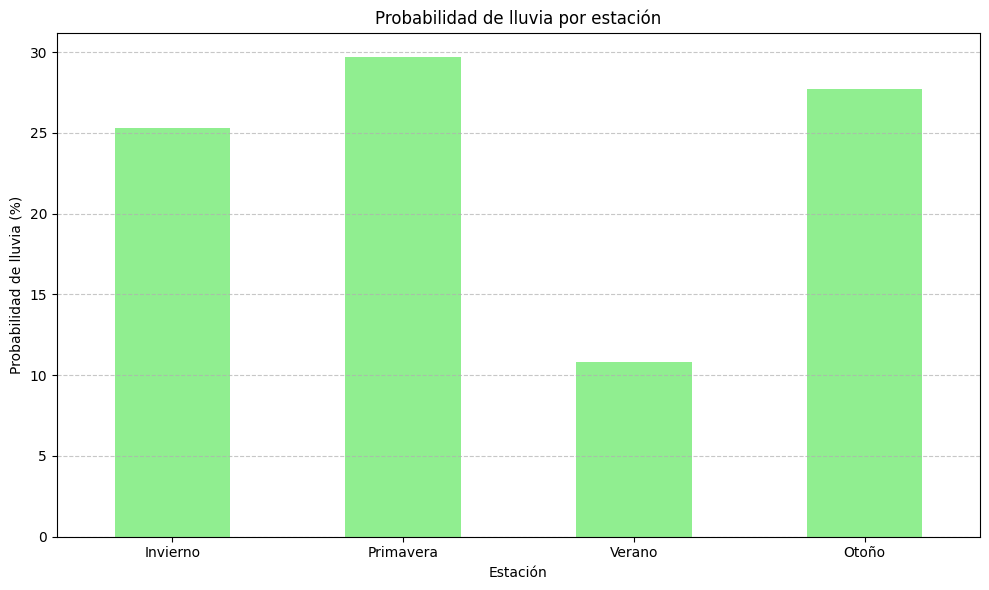

In [12]:
# Analizamos por mes
rain_by_month = df.groupby('month')['rain_tomorrow'].mean() * 100

plt.figure(figsize=(10, 6))
rain_by_month.plot(kind='bar', color='skyblue')
plt.title('Probabilidad de lluvia por mes')
plt.xlabel('Mes')
plt.ylabel('Probabilidad de lluvia (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show

# Analizamos por estación
rain_by_season = df.groupby('season')['rain_tomorrow'].mean() * 100
seasons = {1: 'Invierno', 2: 'Primavera', 3: 'Verano', 4: 'Otoño'}
rain_by_season.index = rain_by_season.index.map(seasons)

plt.figure(figsize=(10, 6))
rain_by_season.plot(kind='bar', color='lightgreen')
plt.title('Probabilidad de lluvia por estación')
plt.xlabel('Estación')
plt.ylabel('Probabilidad de lluvia (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show